## 1) Raw data preprocessing

### Loading raw data

In [1]:
###--- libraries
import pandas as pd
import folium
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
###--- load raw data and make a copy to wort with it
raw_data = pd.read_csv('../raw_data/RawData.csv',sep=';')
data = raw_data.copy()
data.head(5) ### try also data.head(-5)

Fecha-Hora Registro         Direccion Incidente     Tipo_accidente  \
0  2019-06-04T20:44:15.587Z                           0          Atropello   
1  2019-06-04T20:44:15.588Z  CL  052 A   032  000 00000  Caída de Ocupante   
2  2019-06-04T20:44:15.588Z                           0  Caída de Ocupante   
3  2019-06-04T20:44:15.588Z  CR  073 B   091  000 00000          Atropello   
4  2019-06-04T20:44:15.589Z  CR  053   030 A  000 00000               Otro   

                     Georefernecia  AñoAccidente         Barrio  \
0  [-75.7037762763, 6.22141524356]        2014.0            NaN   
1  [-75.5534544709, 6.24349597268]        2014.0  Villa Hermosa   
2  [-75.7037762763, 6.22141524356]        2014.0            NaN   
3  [-75.5792346017, 6.28690605219]        2014.0       Castilla   
4  [-75.5778859663, 6.23258248117]        2014.0          Belén   

              _Direccion    Diseño Via        Barrio.1     Gravedad  \
0  Tramo 9 Kilometro 999  Tramo de via             NaN  Con heridos   
1          CL 52 A CR 32  Tramo de via           Sucre  Con heridos   
2            CR 62 CL 84  Tramo de via             NaN  Con heridos   
3          CR 73 B CL 91  Tramo de via   Alfonso López  Con heridos   
4          CR 53 CL 30 A  Tramo de via  Cerro Nutibara  Con heridos   

  Fecha_Accidente      Hora  Unnamed: 12  Unnamed: 13  
0        12-03-14  10:30:00          NaN          NaN  
1        12-03-14  10:00:00          NaN          NaN  
2        13-03-14   0:20:00          NaN          NaN  
3        12-03-14  23:00:00          NaN          NaN  
4        13-03-14   4:50:00          NaN          NaN

### Data cleaning and preparation

In [51]:
###--- eliminate rows of nan values at the end of the dataset
data = raw_data[:-30000]  

###--- eliminate redundant features
data = data.drop('Fecha-Hora Registro', axis=1)
data = data.drop('Unnamed: 12', axis=1)
data = data.drop('Unnamed: 13', axis=1)
data = data.drop('Direccion Incidente', axis=1)
data = data.drop('_Direccion', axis=1)
data = data.drop('Barrio.1', axis=1)

###--- eliminate instances that have nan values and rename information regarding type of accident
data =  data.dropna()
data['Tipo_accidente'].replace({'Caída de Ocupante': 'Caida Ocupante'}, inplace=True)

###--- eliminate Barrio information that doesn't make sense and discarding data records for 2019
data = data[data.Barrio != '0']
data = data[data.Barrio != 'In']
data = data[data.Barrio != 'AU']
data = data[data.Barrio != 'SN']
data = data[data.AñoAccidente != 2019]

In [52]:
###--- Generate new features of calendar data
data['Date-Time'] = data[['Fecha_Accidente','Hora']].apply(lambda x: ' '.join(x), axis=1) # join fecha-hora to generate datetime column
data['Date-Time'] =  pd.to_datetime(data['Date-Time'])

data = data.sort_values(by=['Date-Time']) # sort values by date to generate a time series
data.head(5)

Tipo_accidente                    Georefernecia  AñoAccidente  \
9440            Otro  [-75.5592064689, 6.26692720514]        2014.0   
9826       Atropello  [-75.5534632834, 6.28938029034]        2014.0   
8089       Atropello   [-75.6076204174, 6.2342063006]        2014.0   
11561      Atropello  [-75.5682712924, 6.25999652159]        2014.0   
11820      Atropello  [-75.5500449822, 6.26480346497]        2014.0   

              Barrio    Diseño Via     Gravedad Fecha_Accidente     Hora  \
9440        Aranjuez  Tramo de via  Con heridos        01-01-14  5:15:00   
9826         Popular  Tramo de via  Con heridos        01-01-14  5:30:00   
8089           Belén  Tramo de via  Con heridos        01-01-14  5:37:00   
11561  La Candelaria  Tramo de via  Con heridos        01-01-14  5:50:00   
11820       Manrique  Tramo de via  Con heridos        01-01-14  6:00:00   

                Date-Time  
9440  2014-01-01 05:15:00  
9826  2014-01-01 05:30:00  
8089  2014-01-01 05:37:00  
11561 2014-01-01 05:50:00  
11820 2014-01-01 06:00:00

In [53]:
###--- extract minute of the date
def m_func(ts): 
    return ts.minute
data['Minute']  = data['Date-Time'].apply(m_func)

###--- extract hour of the date
def hr_func(ts):
    return ts.hour
data['Hour'] = data['Date-Time'].apply(hr_func)

data['Day_of_week'] = data['Date-Time'].dt.dayofweek # extract day of the week from range 0 to 6
data['Day_of_year'] = data['Date-Time'].dt.dayofyear # extract day of the year from range 0 to 364

data['Date'] = [d.date() for d in data['Date-Time']] # Generate date feature without time of the accident
data['Month'] = data['Date-Time'].dt.month

###--- eliminate non-used features after calendar data preprocessing
del data['Fecha_Accidente']
del data['Hora']

data.head(5)

Tipo_accidente                    Georefernecia  AñoAccidente  \
9440            Otro  [-75.5592064689, 6.26692720514]        2014.0   
9826       Atropello  [-75.5534632834, 6.28938029034]        2014.0   
8089       Atropello   [-75.6076204174, 6.2342063006]        2014.0   
11561      Atropello  [-75.5682712924, 6.25999652159]        2014.0   
11820      Atropello  [-75.5500449822, 6.26480346497]        2014.0   

              Barrio    Diseño Via     Gravedad           Date-Time  Minute  \
9440        Aranjuez  Tramo de via  Con heridos 2014-01-01 05:15:00      15   
9826         Popular  Tramo de via  Con heridos 2014-01-01 05:30:00      30   
8089           Belén  Tramo de via  Con heridos 2014-01-01 05:37:00      37   
11561  La Candelaria  Tramo de via  Con heridos 2014-01-01 05:50:00      50   
11820       Manrique  Tramo de via  Con heridos 2014-01-01 06:00:00       0   

       Hour  Day_of_week  Day_of_year        Date  Month  
9440      5            2            1  2014-01-01      1  
9826      5            2            1  2014-01-01      1  
8089      5            2            1  2014-01-01      1  
11561     5            2            1  2014-01-01      1  
11820     6            2            1  2014-01-01      1

In [54]:
###--- Parse and transform geopositional data to generate latitude and  logintude features
data['Georefernecia'] = data['Georefernecia'].map(lambda x: x.lstrip('[').rstrip(']'))
data[['Georefernecia','Latitude']] = data['Georefernecia'].str.split(',',expand=True)
data = data.rename(columns={'Georefernecia': 'Longitude'})

data['Latitude'] = pd.to_numeric(data['Latitude'])
data['Longitude'] = pd.to_numeric(data['Longitude'])

data.head()

Tipo_accidente  Longitude  AñoAccidente         Barrio    Diseño Via  \
9440            Otro -75.559206        2014.0       Aranjuez  Tramo de via   
9826       Atropello -75.553463        2014.0        Popular  Tramo de via   
8089       Atropello -75.607620        2014.0          Belén  Tramo de via   
11561      Atropello -75.568271        2014.0  La Candelaria  Tramo de via   
11820      Atropello -75.550045        2014.0       Manrique  Tramo de via   

          Gravedad           Date-Time  Minute  Hour  Day_of_week  \
9440   Con heridos 2014-01-01 05:15:00      15     5            2   
9826   Con heridos 2014-01-01 05:30:00      30     5            2   
8089   Con heridos 2014-01-01 05:37:00      37     5            2   
11561  Con heridos 2014-01-01 05:50:00      50     5            2   
11820  Con heridos 2014-01-01 06:00:00       0     6            2   

       Day_of_year        Date  Month  Latitude  
9440             1  2014-01-01      1  6.266927  
9826             1  2014-01-01      1  6.289380  
8089             1  2014-01-01      1  6.234206  
11561            1  2014-01-01      1  6.259997  
11820            1  2014-01-01      1  6.264803

In [55]:
###--- Reset index
data = data.reset_index()
del data['index']
data.head(5)

Tipo_accidente  Longitude  AñoAccidente         Barrio    Diseño Via  \
0           Otro -75.559206        2014.0       Aranjuez  Tramo de via   
1      Atropello -75.553463        2014.0        Popular  Tramo de via   
2      Atropello -75.607620        2014.0          Belén  Tramo de via   
3      Atropello -75.568271        2014.0  La Candelaria  Tramo de via   
4      Atropello -75.550045        2014.0       Manrique  Tramo de via   

      Gravedad           Date-Time  Minute  Hour  Day_of_week  Day_of_year  \
0  Con heridos 2014-01-01 05:15:00      15     5            2            1   
1  Con heridos 2014-01-01 05:30:00      30     5            2            1   
2  Con heridos 2014-01-01 05:37:00      37     5            2            1   
3  Con heridos 2014-01-01 05:50:00      50     5            2            1   
4  Con heridos 2014-01-01 06:00:00       0     6            2            1   

         Date  Month  Latitude  
0  2014-01-01      1  6.266927  
1  2014-01-01      1  6.289380  
2  2014-01-01      1  6.234206  
3  2014-01-01      1  6.259997  
4  2014-01-01      1  6.264803

## 2)  Exploratory Data Analysis and Observations

#### Which months are road traffic accidents most likely to occur (2014-2018)?
1. Accidents occurred for each day of the week in all calendar months
2. Accidents occurred for each day of the week in all calendar months
3. Create matrix for heatmap using data coming from steps 1 and 2
4. Plot

In [58]:
###--- Function to calculate the accidents occurred for each day of the week in all calendar months (2014-2018)
def RTAs_by_month(df, month, month_name):
    month_list = []
    mon, tues, wed, thurs, fri, sat, sun = 0,0,0,0,0,0,0
    
    for idx, row in df.iterrows():
        if row['Month'] == month and row['Day_of_week'] == 0: mon +=1
        elif row['Month'] == month and row['Day_of_week'] == 1: tues +=1
        elif row['Month'] == month and row['Day_of_week'] == 2: wed +=1
        elif row['Month'] == month and row['Day_of_week'] == 3: thurs +=1
        elif row['Month'] == month and row['Day_of_week'] == 4: fri +=1
        elif row['Month'] == month and row['Day_of_week'] == 5: sat +=1
        elif row['Month'] == month and row['Day_of_week'] == 6: sun +=1

    month_list.append(mon)
    month_list.append(tues)
    month_list.append(wed)
    month_list.append(thurs)
    month_list.append(fri)
    month_list.append(sat)
    month_list.append(sun)
    
    print(month_name, ": ", month_list)
    
    return(month_list)

In [61]:
###--- Extract road accidents for each day by month along all years
january = RTAs_by_month(data, 1, 'january')
february = RTAs_by_month(data, 2, 'february')
march = RTAs_by_month(data, 3, 'march')
april = RTAs_by_month(data, 4, 'april')
may = RTAs_by_month(data,5, 'may')
june = RTAs_by_month(data, 6, 'june')
july = RTAs_by_month(data, 7, 'july')
august = RTAs_by_month(data, 8, 'august')
september = RTAs_by_month(data, 9, 'september')
october = RTAs_by_month(data, 10, 'october')
november = RTAs_by_month(data, 11, 'november')
december = RTAs_by_month(data, 12, 'december')

january  :  [2591, 2623, 2575, 2590, 2786, 2505, 1943]
february  :  [2610, 2472, 2385, 2430, 2581, 2330, 2085]
march  :  [2626, 2606, 2641, 2811, 2622, 2497, 2350]
april  :  [2647, 2493, 2687, 2642, 2495, 2448, 2210]
may  :  [2590, 2881, 2739, 2615, 2874, 2763, 2180]
june  :  [2466, 2638, 2570, 2542, 2621, 2450, 2142]
july  :  [2794, 2729, 2758, 2948, 2711, 2499, 2399]
august  :  [2532, 2705, 2763, 2807, 2784, 2685, 2129]
september  :  [2521, 2706, 2695, 2636, 2857, 2677, 2096]
october  :  [2596, 2810, 2644, 2788, 2984, 2654, 2176]
november  :  [2798, 2910, 3120, 3030, 2887, 2654, 2331]
december  :  [2763, 2825, 3092, 2978, 2998, 2876, 2442]


In [65]:
###--- Create matrix for heatmap
columns = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
rows = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
data_days_months = np.array([january, february, march, april, may, june, july, august, september, october, november, december])
heatmap_df = pd.DataFrame(data=data_days_months, index=rows, columns=columns)
heatmap_df.head(12)

Monday  Tuesday  Wednesday  Thursday  Friday  Saturday  Sunday
January      2591     2623       2575      2590    2786      2505    1943
February     2610     2472       2385      2430    2581      2330    2085
March        2626     2606       2641      2811    2622      2497    2350
April        2647     2493       2687      2642    2495      2448    2210
May          2590     2881       2739      2615    2874      2763    2180
June         2466     2638       2570      2542    2621      2450    2142
July         2794     2729       2758      2948    2711      2499    2399
August       2532     2705       2763      2807    2784      2685    2129
September    2521     2706       2695      2636    2857      2677    2096
October      2596     2810       2644      2788    2984      2654    2176
November     2798     2910       3120      3030    2887      2654    2331
December     2763     2825       3092      2978    2998      2876    2442

In [67]:
###--- Plotting
fig = plt.figure(figsize=(15,15),dpi=800)
map1 = sns.heatmap(heatmap_df, annot=True, fmt='d', cmap='BuPu', cbar_kws={'orientation': 'horizontal'} )
map1.set_title('Accidents occurred for each day of the week in all calendar months (2014-2018)')
plt.savefig('../results/plots/Accidents_by_day_for_each_month_2014-2018.png', dpi=800)

#### What time of the day are road traffic accidents most likely to occur (2014-2018)?
1. Determine what time of the day are road traffic accidents most likely to occur
2. Extract road accidents about how many traffic accidents have occurred in each hour for each day of the week
3. Create matrix for heatmap using data coming from steps 1 and 2
4. Plot

In [68]:
###--- Function to determine what time of the day are road traffic accidents most likely to occur (2014-2018)
def RTAs_by_hour(df, hour):
    hour_list = []
    mon, tues, wed, thurs, fri, sat, sun = 0,0,0,0,0,0,0
    
    for idx, row in df.iterrows():
        if row['Hour'] == hour and row['Day_of_week'] == 0: mon +=1
        elif row['Hour'] == hour and row['Day_of_week'] == 1: tues +=1
        elif row['Hour'] == hour and row['Day_of_week'] == 2: wed +=1
        elif row['Hour'] == hour and row['Day_of_week'] == 3: thurs +=1
        elif row['Hour'] == hour and row['Day_of_week'] == 4: fri +=1
        elif row['Hour'] == hour and row['Day_of_week'] == 5: sat +=1
        elif row['Hour'] == hour and row['Day_of_week'] == 6: sun +=1

    
    hour_list.append(mon)
    hour_list.append(tues)
    hour_list.append(wed)
    hour_list.append(thurs)
    hour_list.append(fri)
    hour_list.append(sat)
    hour_list.append(sun)
    
    print(hour_list)
    
    return(hour_list)

In [69]:
###--- Extract road accidents about how many traffic accidents have occurred in each hour for each day of the week
hour_0 = RTAs_by_hour(data, 0)
hour_1 = RTAs_by_hour(data, 1)
hour_2 = RTAs_by_hour(data, 2)
hour_3 = RTAs_by_hour(data, 3)
hour_4 = RTAs_by_hour(data, 4)
hour_5 = RTAs_by_hour(data, 5)
hour_6 = RTAs_by_hour(data, 6)
hour_7 = RTAs_by_hour(data, 7)
hour_8 = RTAs_by_hour(data, 8)
hour_9 = RTAs_by_hour(data, 9)
hour_10 = RTAs_by_hour(data, 10)
hour_11 = RTAs_by_hour(data, 11)
hour_12 = RTAs_by_hour(data, 12)
hour_13 = RTAs_by_hour(data, 13)
hour_14 = RTAs_by_hour(data, 14)
hour_15 = RTAs_by_hour(data, 15)
hour_16 = RTAs_by_hour(data, 16)
hour_17 = RTAs_by_hour(data, 17)
hour_18 = RTAs_by_hour(data, 18)
hour_19 = RTAs_by_hour(data, 19)
hour_20 = RTAs_by_hour(data, 20)
hour_21 = RTAs_by_hour(data, 21)
hour_22 = RTAs_by_hour(data, 22)
hour_23 = RTAs_by_hour(data, 23)

[1223, 1542, 1717, 1596, 1610, 1610, 1505]
[1150, 1255, 1229, 1371, 1278, 1369, 1360]
[882, 929, 1053, 1036, 1060, 1156, 1100]
[732, 642, 679, 650, 679, 795, 932]
[434, 356, 346, 370, 342, 454, 562]
[343, 243, 228, 258, 258, 389, 514]
[468, 350, 402, 439, 459, 557, 587]
[425, 367, 354, 416, 361, 486, 588]
[383, 360, 315, 346, 392, 495, 527]
[465, 430, 390, 431, 498, 523, 639]
[1001, 1079, 988, 1121, 1085, 887, 853]
[1963, 2129, 2121, 2137, 2148, 1461, 1189]
[2256, 2336, 2257, 2300, 2384, 1617, 1292]
[1678, 1760, 1833, 1818, 1767, 1561, 1129]
[1564, 1583, 1649, 1664, 1542, 1568, 1156]
[1556, 1713, 1708, 1717, 1779, 1657, 1276]
[1701, 1838, 1821, 1707, 1794, 1830, 1404]
[1992, 1987, 2008, 2086, 1926, 2147, 1534]
[1750, 1823, 1802, 1755, 1743, 1900, 1410]
[1688, 1754, 1817, 1780, 1838, 1826, 1361]
[1771, 1834, 1834, 1776, 1863, 1788, 1427]
[1957, 1873, 1935, 1890, 2079, 1750, 1431]
[2220, 2249, 2273, 2291, 2316, 1713, 1379]
[1932, 1966, 1910, 1862, 1999, 1499, 1328]


In [70]:
###--- Create matrix for heatmap
columns = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
rows = ['0', '1am', '2am', '3am', '4am', '5am', '6am', '7am', '8am', '9am', '10am', '11am', '12pm', '1pm', '2pm', '3pm','4pm','5pm','6pm','7pm','8pm','9pm','10pm','11pm']
data_hours_of_days = np.array([hour_0, hour_1, hour_2, hour_3, hour_4, hour_5, hour_6, hour_7, hour_8, hour_9, hour_10, hour_11, hour_12, hour_13, hour_14, hour_15, hour_16, hour_17, hour_18, hour_19, hour_20, hour_21, hour_22, hour_23])
heatmap_hour = pd.DataFrame(data=data_hours_of_days, index=rows, columns=columns)
heatmap_hour.head(24)

Monday  Tuesday  Wednesday  Thursday  Friday  Saturday  Sunday
0       1223     1542       1717      1596    1610      1610    1505
1am     1150     1255       1229      1371    1278      1369    1360
2am      882      929       1053      1036    1060      1156    1100
3am      732      642        679       650     679       795     932
4am      434      356        346       370     342       454     562
5am      343      243        228       258     258       389     514
6am      468      350        402       439     459       557     587
7am      425      367        354       416     361       486     588
8am      383      360        315       346     392       495     527
9am      465      430        390       431     498       523     639
10am    1001     1079        988      1121    1085       887     853
11am    1963     2129       2121      2137    2148      1461    1189
12pm    2256     2336       2257      2300    2384      1617    1292
1pm     1678     1760       1833      1818    1767      1561    1129
2pm     1564     1583       1649      1664    1542      1568    1156
3pm     1556     1713       1708      1717    1779      1657    1276
4pm     1701     1838       1821      1707    1794      1830    1404
5pm     1992     1987       2008      2086    1926      2147    1534
6pm     1750     1823       1802      1755    1743      1900    1410
7pm     1688     1754       1817      1780    1838      1826    1361
8pm     1771     1834       1834      1776    1863      1788    1427
9pm     1957     1873       1935      1890    2079      1750    1431
10pm    2220     2249       2273      2291    2316      1713    1379
11pm    1932     1966       1910      1862    1999      1499    1328

In [71]:
###--- Plotting
fig = plt.figure(figsize=(15,15),dpi=800)
ax = sns.heatmap(heatmap_hour, annot=True, fmt='d', cmap='BuPu', cbar_kws={'orientation': 'horizontal'} )
ax.set_title('Traffic Accidents by hour for each day from 2014-2018')
plt.savefig('../results/plots/Accidents_by_hour_for_each_day_2014-2018.png', dpi=800)

#### In which neighborhoods do traffic accidents occur most often (2014-2018)?

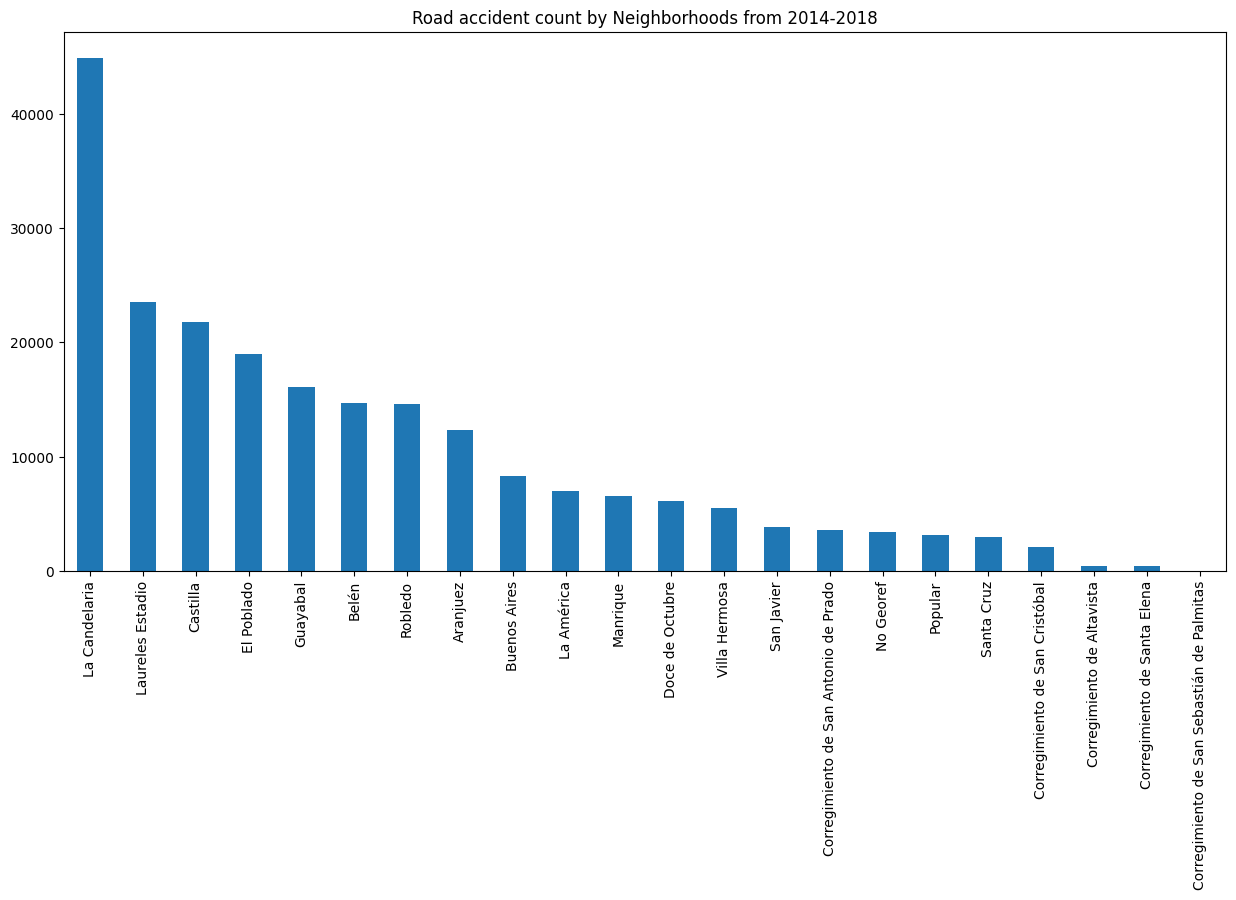

In [77]:
fig = plt.figure(figsize=(15,7))
ax = data['Barrio'].value_counts().plot(kind = 'bar')
ax.set_title('Road accident count by Neighborhoods from 2014-2018')
plt.savefig('../results/plots/Accidents_by_neighborhoods_2014-2018.png', dpi=700)

#### What is th severity of the accidents along the years (2014-2018)?
1. Accident severity total count from 2014 to 2018
2. Accident severity count diaggregated by year from 2014 to 2018

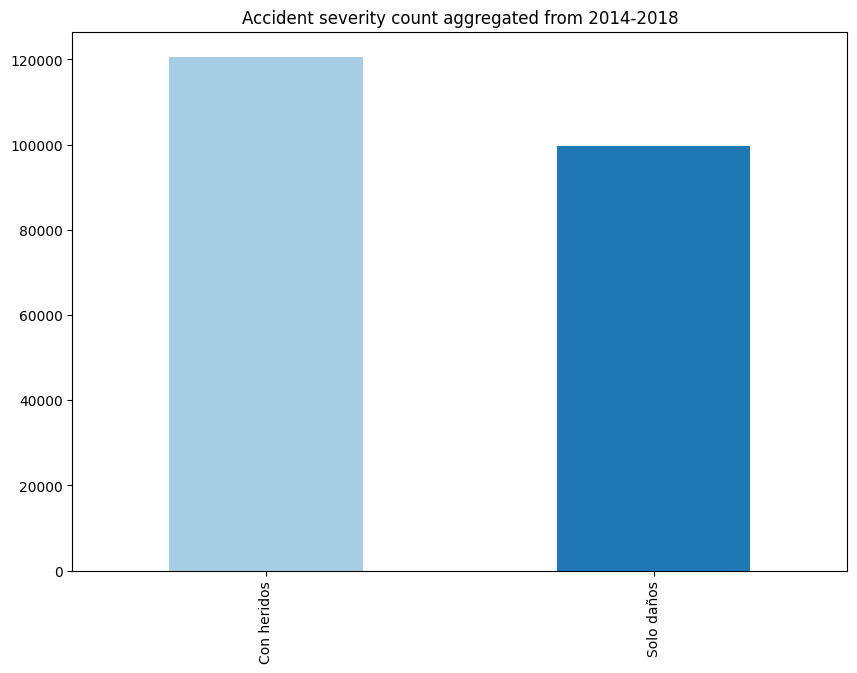

In [78]:
###--- Accident severity total count from 2014 to 2018
fig = plt.figure(figsize=(10,7))
ax = data['Gravedad'].value_counts().plot(kind='bar',color=plt.cm.Paired(np.arange(len(data))))
ax.set_title('Accident severity count aggregated from 2014-2018')
plt.savefig('../results/plots/AccidentSeverity_count_aggregated_2014-2018.png', dpi=700)

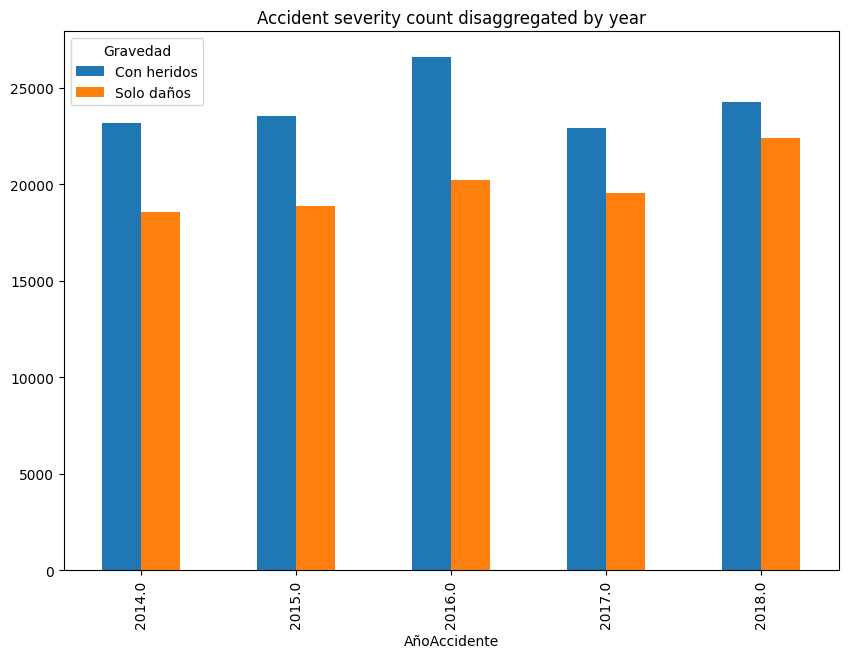

In [80]:
###--- Accident severity count diaggregated by year from 2014 to 2018
AccidentSeverity_x_year = pd.DataFrame()
AccidentSeverity_x_year = data.groupby('AñoAccidente')['Gravedad'].value_counts().unstack()
fig, ax1 = plt.subplots(figsize=(10,7))
AccidentSeverity_x_year.plot.bar(ax=ax1)
ax1.set_title('Accident severity count disaggregated by year')
plt.savefig('../results/plots/AccidentSeverity_count_disaggregated_by_year.png', dpi=700)

####  What are the types of road accidents along the years? (2014-2018)?
1. Accident type count aggregated from 2014 to 2018
2. Accident type count diaggregated by year from 2014 to 2018

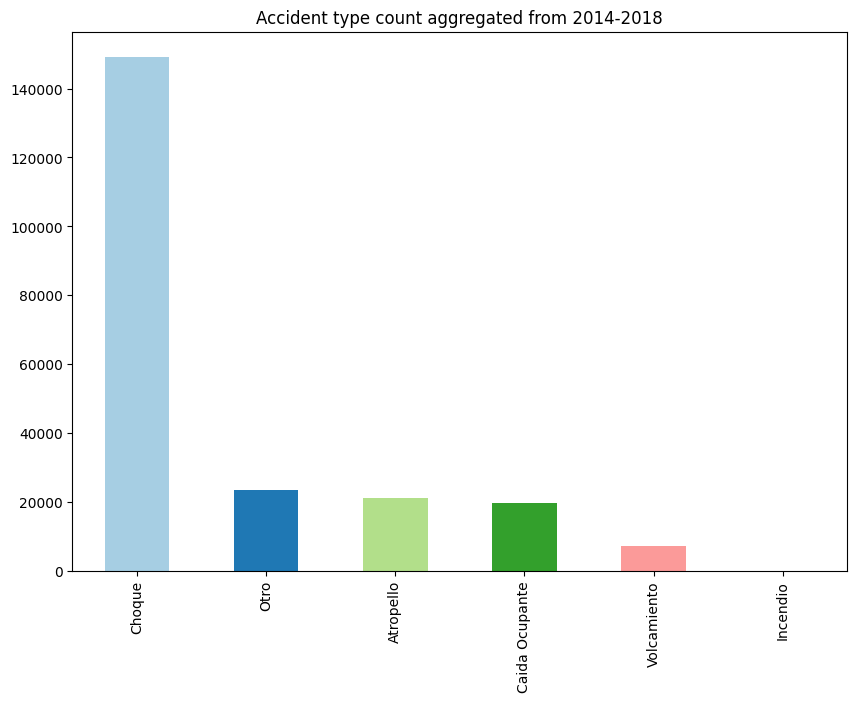

In [81]:
###--- Accident type count aggregated from 2014 to 2018
fig = plt.figure(figsize=(10,7))
ax = data['Tipo_accidente'].value_counts().plot(kind='bar',color=plt.cm.Paired(np.arange(len(data))))
ax.set_title('Accident type count aggregated from 2014-2018')
plt.savefig('../results/plots/AccidentType_count_aggregated_2014-2018.png', dpi=700)

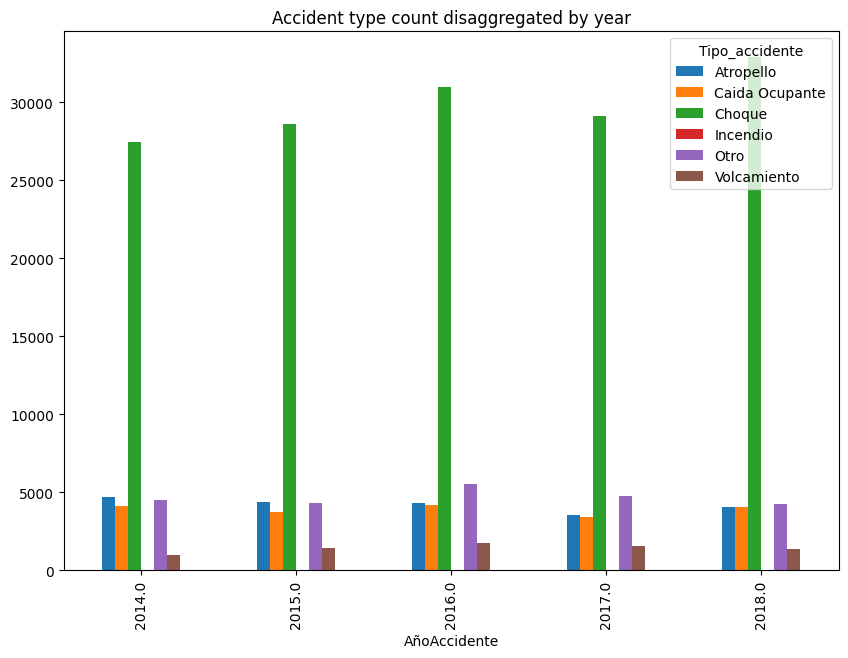

In [82]:
###--- Accident type count diaggregated by year from 2014 to 2018
AccidentType_x_year = pd.DataFrame()
AccidentType_x_year = data.groupby('AñoAccidente')['Tipo_accidente'].value_counts().unstack()
fig, ax1 = plt.subplots(figsize=(10,7))
AccidentType_x_year.plot.bar(ax=ax1)
ax1.set_title('Accident type count disaggregated by year')
plt.savefig('../results/plots/AccidentType_count_disaggregated_by_year.png', dpi=700)

### Accidents distributed across Medellín

In [84]:
###--- Plot map of road accident locations
Map_Medellin = folium.Map(location=[6.2528623,-75.592885],zoom_start=13)
# I can add marker one by one on the map
for i in range(0,2000):
    folium.Circle([data.iloc[i]['Latitude'], data.iloc[i]['Longitude']], radius=0.5,
                  color='crimson', fill=True, fill_color='crimson').add_to(Map_Medellin)    
Map_Medellin.save('../results/Map_Accidents_Medellin.html')

## 3) Supervised learning modelling for crash secerity prediction

####  Datasets preparation (2014-2018)

In [86]:
###--- save dataset for supervised learning
dataset = data.copy()

###-- Delete redundant features
del dataset['Barrio']
del dataset['Date-Time']
del dataset['Date']

###--- Identify and code dataset classes (objective varibale to be predicted). In this way, we will have a dataset
###--- for supervised multiclass prediction
conditions = [(dataset['Gravedad'] == 'Solo daños'), 
             (dataset['Gravedad'] == 'Con heridos'),
              (dataset['Gravedad'] == 'Con muertos')]
choices = ['0', '1', '2']
dataset['Class'] = np.select(conditions, choices, default=np.nan)
del dataset['Gravedad']

dataset.head(5)

Tipo_accidente  Longitude  AñoAccidente    Diseño Via  Minute  Hour  \
0           Otro -75.559206        2014.0  Tramo de via      15     5   
1      Atropello -75.553463        2014.0  Tramo de via      30     5   
2      Atropello -75.607620        2014.0  Tramo de via      37     5   
3      Atropello -75.568271        2014.0  Tramo de via      50     5   
4      Atropello -75.550045        2014.0  Tramo de via       0     6   

   Day_of_week  Day_of_year  Month  Latitude Class  
0            2            1      1  6.266927     1  
1            2            1      1  6.289380     1  
2            2            1      1  6.234206     1  
3            2            1      1  6.259997     1  
4            2            1      1  6.264803     1

In [90]:
###--- Generate a dataset for each year
dataset_2014 = pd.DataFrame()
dataset_2014 = dataset[dataset['AñoAccidente'] == 2014]
del dataset_2014 ['AñoAccidente']
dataset_2014.to_csv('../datasets/2014_AccidentSeverity.csv',index=False)

dataset_2015 = pd.DataFrame()
dataset_2015 = dataset[dataset['AñoAccidente'] == 2015]
del dataset_2015 ['AñoAccidente']
dataset_2015.to_csv('../datasets/2015_AccidentSeverity.csv',index=False)

dataset_2016 = pd.DataFrame()
dataset_2016 = dataset[dataset['AñoAccidente'] == 2016]
del dataset_2016 ['AñoAccidente']
dataset_2016.to_csv('../datasets/2016_AccidentSeverity.csv',index=False)

dataset_2017 = pd.DataFrame()
dataset_2017 = dataset[dataset['AñoAccidente'] == 2017]
del dataset_2017 ['AñoAccidente']
dataset_2017.to_csv('../datasets/2017_AccidentSeverity.csv',index=False)

dataset_2018 = pd.DataFrame()
dataset_2018 = dataset[dataset['AñoAccidente'] == 2018]
del dataset_2018 ['AñoAccidente']
dataset_2018.to_csv('../datasets/2018_AccidentSeverity.csv',index=False)